In [11]:
###
# Name: Jason van Hamond
# Project: Duckietown, classes
###
import numpy as np
from gym_duckietown.simulator import get_right_vec
from roboflow import Roboflow
import math

# Initialize variables.
pos = 0.04
vel = 0.8
gain = 20
fol = 0.5


class TrackingExpert:
    def __init__(self, env, velocity=vel, position=pos, following_distance=fol, max_it=1000):
        self.env = env.unwrapped
        self.following_distance = following_distance
        self.max_it = max_it
        self.velocity = velocity
        self.position = position
    # Predict movement.
    def predict(self, observation):
        # Get closest point and closest tangent.
        closest_point, closest_tangent = self.env.closest_curve_point(self.env.cur_pos, self.env.cur_angle)
        # Initialize/Set the other variables.
        i = 0
        following_distance = self.following_distance
        curve_point = None
        curve_point_obj = None
        while(i < self.max_it):
            # Calculate follow point
            follow_point = closest_point + closest_tangent * following_distance
            # Get curve point with the follow point and current angle.
            curve_point, _ = self.env.closest_curve_point(follow_point, self.env.cur_angle)
                
            if(curve_point is not None):
                break
            i += 1
            following_distance *= 0.7
        # Calculate point vec.
        point_vec = curve_point - self.env.cur_pos
        point_vec /= np.linalg.norm(point_vec)
            
        dot = np.dot(get_right_vec(self.env.cur_angle), point_vec)
        steering = gain * -dot

        # Object detection (WIP), NOT FULLY WORKING YET!!
        # for obj in self.env.collidable_corners:
        #     obj1 = obj[0]
        #     obj2 = obj[1]
        #     if(math.isclose(obj1[0].astype(float), self.env.cur_pos[0].astype(float), abs_tol =  0.2)
        #       and math.isclose(obj2[0].astype(float), self.env.cur_pos[2].astype(float), abs_tol = 0.2)
        #       or math.isclose(obj1[1].astype(float), self.env.cur_pos[0].astype(float), abs_tol =  0.2)
        #       and math.isclose(obj2[2].astype(float), self.env.cur_pos[2].astype(float), abs_tol = 0.2)
        #       or math.isclose(obj1[3].astype(float), self.env.cur_pos[0].astype(float), abs_tol =  0.2)
        #       and math.isclose(obj2[3].astype(float), self.env.cur_pos[2].astype(float), abs_tol = 0.2)):
        #         if(dot < 0.8 and dot > -0.8):
        #             # Check if object detected, remove later
        #             print("object")
        #             # Change steering accordingly.
        #             return self.velocity * 0.5, self.env.cur_angle * 5 * -(3 * (obj1[0] - self.env.cur_pos[0]))
        
        # Check if Duckie is getting close to a turn or wall.
        if(dot > 0.8 or dot < -0.8):
            # Brake and steer away.
            velocity = 0
            return velocity, steering * 0.2

        return self.velocity, steering

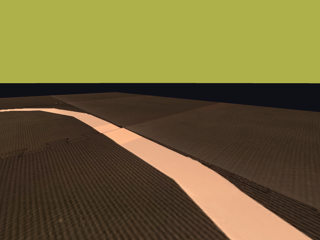

In [14]:
###
# Name: Jason van Hamond
# Project: Duckietown
###
import gym
import gym_duckietown
from IPython.display import display, clear_output
from PIL import Image

env = gym.make('Duckietown-zigzag_dists-v0')
env.reset()


expert = TrackingExpert(env=env, velocity = 1, following_distance = 0.4)

def show_arr(arr):
    img = Image.fromarray(arr, 'RGB')
    img = img.resize((320, 240))
    display(img)

done = False
while(not done):
    action = expert.predict(None)
    observation, reward, done, info = env.step(action)
    frame = env.render(mode='rgb_array')
    clear_output(wait=True)
    show_arr(frame)

env.close()